## Load required liabries and data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('vehicles.csv')

## Data cleaning 
### Choosing variables and filtering out irrelevant entries

In [3]:
variables = ['comb08','displ','atvType','barrels08','city08','co2TailpipeGpm','cylinders','drive','feScore', 
             'fuelCost08','fuelType','ghgScore','highway08','hlv','hpv','lv2','lv4','mpgData', 
             'pv2','pv4','UCity','UHighway','year','guzzler','tCharger','sCharger','startStop','trany','VClass']
data2 = data[variables]

# Only cars made in year 1984-2022 should be included. 
data2 = data2[data2.year.isin(range(1984,2022))] 

# only vehicles with these fuel types are considered
data2 = data2[data2.fuelType.isin(['Regular', 'Premium', 'Diesel', 'Midgrade'])] 
data2 = data2[~data2.atvType.isin(['Hybrid'])]
variables.remove('atvType')
data2.drop(columns = ['atvType'], inplace = True)

# Converting sCharger and tCharger to dummy variables
data2.tCharger.replace([np.nan,'T'],[0,1],inplace = True)
data2.sCharger.replace([np.nan,'S'],[0,1],inplace = True)
# Converting guzzler to a dummy variable: 1 if this vehicle is subject to the gas guzzler tax and 0 otherwise
data2.guzzler.replace(['T','G','S',np.nan],[1,1,0,0],inplace = True)
# Converting startStop to a dummy variable: 1 if this vehicle has start-stop technology
data2.startStop.replace(['Y','N',np.nan],[1,0,0],inplace = True)
# Converting mpgData to a dummy variable: 1 if this vehicle has mpg Data
data2.mpgData.replace(['Y','N'],[1,0],inplace = True)

# Converting year built to age of the vehicle
variables.append('age'); variables.remove('year');
data2['age'] = 2023 - data2.year
data2.drop(columns = ['year'], inplace = True)

# Converting createdOn and modifiedOn to Pandas DateTime
# data2.modifiedOn = pd.to_datetime(data2.modifiedOn)
# data2.createdOn = pd.to_datetime(data2.createdOn)

# Converting trany into a Categorical variable with 'Automatic', 'Manual', and -1 (na) being the groups
data2.trany[data2.trany.astype(str).str.startswith('Automatic')] = 'Automatic'
data2.trany[data2.trany.astype(str).str.startswith('Manual')] = 'Manual'
data2.trany.replace([np.nan],[-1],inplace = True) # only two obs in this group

numerical = ['displ','barrels08','city08','co2TailpipeGpm','cylinders','fuelCost08','highway08','hlv','hpv',
             'lv2','lv4','pv2','pv4','UCity','UHighway','age']
categorical = ['drive','fuelType','mpgData','guzzler','tCharger','sCharger','startStop',
               'feScore', 'ghgScore','trany','VClass'] # Deal with these later
# Remove missing values
data2.drop(data2[data2.displ.isna()].index, inplace = True)
data2.drop(data2[data2.comb08.isna()].index, inplace = True)
data2.drop(data2[data2.trany == -1].index, inplace = True)
print(data2.shape)
data2.head()

(40575, 28)


,comb08,displ,barrels08,city08,co2TailpipeGpm,cylinders,drive,feScore,fuelCost08,fuelType,...,pv4,UCity,UHighway,guzzler,tCharger,sCharger,startStop,trany,VClass,age
0,21,2.0,14.167143,19,423.190476,4.0,Rear-Wheel Drive,-1,2650,Regular,...,0,23.3333,35.0000,0.0,0,0,0.0,Manual,Two Seaters,38
1,11,4.9,27.046364,9,807.909091,12.0,Rear-Wheel Drive,-1,5050,Regular,...,0,11.0000,19.0000,1.0,0,0,0.0,Manual,Two Seaters,38
2,27,2.2,11.018889,23,329.148148,4.0,Front-Wheel Drive,-1,2050,Regular,...,0,29.0000,47.0000,0.0,0,0,0.0,Manual,Subcompact Cars,38
3,11,5.2,27.046364,10,807.909091,8.0,Rear-Wheel Drive,-1,5050,Regular,...,0,12.2222,16.6667,0.0,0,0,0.0,Automatic,Vans,38
4,19,2.2,15.658421,17,467.736842,4.0,4-Wheel or All-Wheel Drive,-1,3650,Premium,...,90,21.0000,32.0000,0.0,1,0,0.0,Manual,Compact Cars,30


### Splitting training and test data

In [4]:
state= 1490981583

train = data2.sample(frac=0.75, random_state=state)
test = data2[data2.index.isin(train.index)==False].copy() # Only for prediction

train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

In [5]:
data2.shape

(40575, 28)

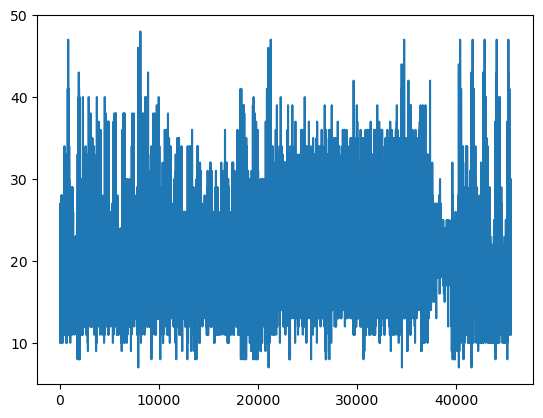

In [6]:
plt.plot(data2['comb08'])

(array([  696.,  6042., 12799., 11925.,  5912.,  2164.,   803.,   157.,
           64.,    13.]),
 array([ 7. , 11.1, 15.2, 19.3, 23.4, 27.5, 31.6, 35.7, 39.8, 43.9, 48. ]),
 <BarContainer object of 10 artists>)

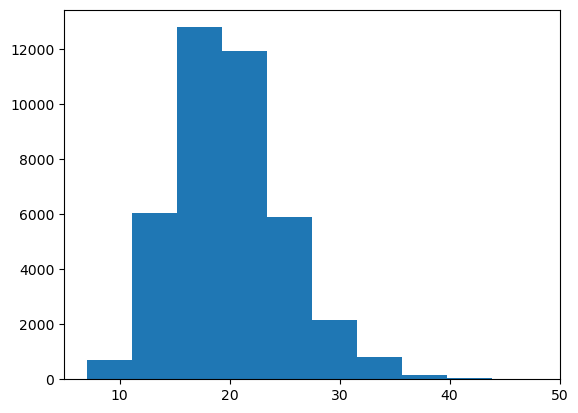

In [7]:
plt.hist(data2['comb08'])

In [8]:
train.head()

,comb08,displ,barrels08,city08,co2TailpipeGpm,cylinders,drive,feScore,fuelCost08,fuelType,...,pv4,UCity,UHighway,guzzler,tCharger,sCharger,startStop,trany,VClass,age
0,19,3.1,15.658421,16,467.736842,6.0,Rear-Wheel Drive,-1,2950,Regular,...,0,20.0000,35.0000,0.0,0,0,0.0,Automatic,Subcompact Cars,33
1,19,3.0,15.658421,16,467.736842,6.0,Front-Wheel Drive,-1,2950,Regular,...,104,20.0000,34.0000,0.0,0,0,0.0,Automatic,Large Cars,35
2,20,2.4,14.875500,18,444.350000,4.0,Front-Wheel Drive,-1,2800,Regular,...,0,22.6224,33.8775,0.0,0,0,0.0,Automatic,Minicompact Cars,20
3,18,2.7,16.528333,16,493.722222,4.0,Rear-Wheel Drive,-1,3850,Premium,...,0,20.0000,28.2051,0.0,0,0,0.0,Automatic,Minicompact Cars,34
4,21,2.5,14.167143,18,423.190476,6.0,Rear-Wheel Drive,-1,3300,Premium,...,91,22.6379,37.6438,0.0,0,0,0.0,Manual,Compact Cars,21


## EDA

In [9]:
train.describe()

,comb08,displ,barrels08,city08,co2TailpipeGpm,cylinders,feScore,fuelCost08,ghgScore,highway08,...,mpgData,pv2,pv4,UCity,UHighway,guzzler,tCharger,sCharger,startStop,age
count,30431.000000,30431.000000,30431.000000,30431.000000,30431.000000,30431.000000,30431.000000,30431.000000,30431.000000,30431.000000,...,30431.000000,30431.000000,30431.000000,30431.000000,30431.000000,30431.000000,30431.000000,30431.000000,30431.000000,30431.00000
mean,20.222010,3.256528,15.681060,17.892018,467.596176,5.678617,0.410798,3165.241037,0.405310,24.218100,...,0.315139,14.113404,33.709868,22.509895,33.986460,0.061681,0.195754,0.020473,0.086754,21.16401
std,4.906112,1.342581,3.896865,4.473999,116.192261,1.758309,2.620426,854.575095,2.608783,5.742805,...,0.464579,31.575172,45.972533,6.078337,8.571396,0.240578,0.396787,0.141612,0.281478,11.61151
min,7.000000,0.900000,6.330000,6.000000,189.085106,2.000000,-1.000000,1200.000000,-1.000000,9.000000,...,0.000000,0.000000,0.000000,7.000000,12.000000,0.000000,0.000000,0.000000,0.000000,2.00000
25%,17.000000,2.200000,12.935217,15.000000,386.391304,4.000000,-1.000000,2550.000000,-1.000000,20.000000,...,0.000000,0.000000,0.000000,18.500000,28.000000,0.000000,0.000000,0.000000,0.000000,11.00000
50%,20.000000,3.000000,14.875500,17.000000,444.350000,6.000000,-1.000000,3100.000000,-1.000000,24.000000,...,0.000000,0.000000,0.000000,21.545000,33.333300,0.000000,0.000000,0.000000,0.000000,21.00000
75%,23.000000,4.200000,17.500588,20.000000,522.764706,6.000000,-1.000000,3650.000000,-1.000000,28.000000,...,1.000000,0.000000,91.000000,25.900000,39.000000,0.000000,0.000000,0.000000,0.000000,32.00000
max,47.000000,8.400000,42.501429,44.000000,1269.571429,16.000000,9.000000,9850.000000,9.000000,52.000000,...,1.000000,194.000000,192.000000,60.000000,77.700000,1.000000,1.000000,1.000000,1.000000,39.00000


DescribeResult(nobs=30431, minmax=(7, 47), mean=20.222010449870197, variance=24.06993418996638, skewness=0.6673959857433651, kurtosis=0.8931902887045235)
             comb08
count  30431.000000
mean      20.222010
std        4.906112
min        7.000000
25%       17.000000
50%       20.000000
75%       23.000000
max       47.000000


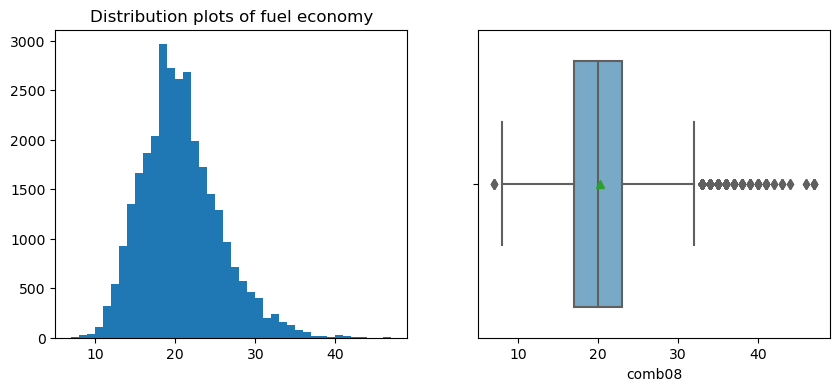

In [10]:
# We want to explore the fuel economy (comb08) and engine displacement (displ) variables

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(train["comb08"], bins = 40)
plt.title("Distribution plots of fuel economy");

plt.subplot(1,2,2)
sns.boxplot(x="comb08", data=train, palette="Blues", showmeans=True);

a = stats.describe(train['comb08'])
b = train[["comb08"]].describe()

print(a)
print(b)

DescribeResult(nobs=30431, minmax=(0.9, 8.4), mean=3.256527882751142, variance=1.8025238493621913, skewness=0.7032423734188402, kurtosis=-0.3807299675578175)
              displ
count  30431.000000
mean       3.256528
std        1.342581
min        0.900000
25%        2.200000
50%        3.000000
75%        4.200000
max        8.400000


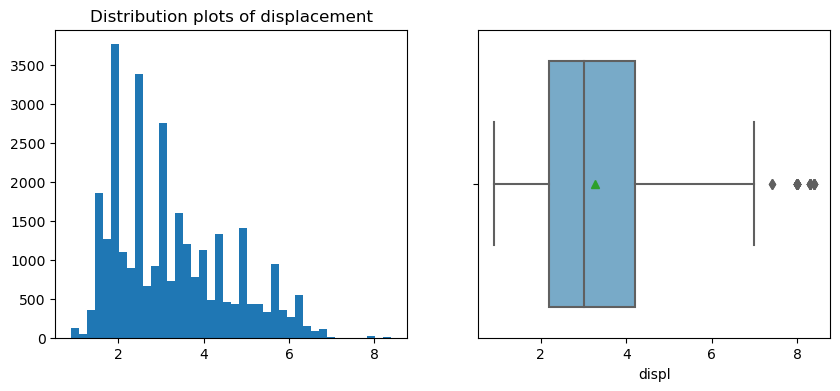

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(train['displ'], bins = 40)
plt.title("Distribution plots of displacement");

plt.subplot(1,2,2)
sns.boxplot(x="displ", data=train, palette="Blues", showmeans=True);

a = stats.describe(train['displ'])
b = train[["displ"]].describe()

print(a)
print(b)

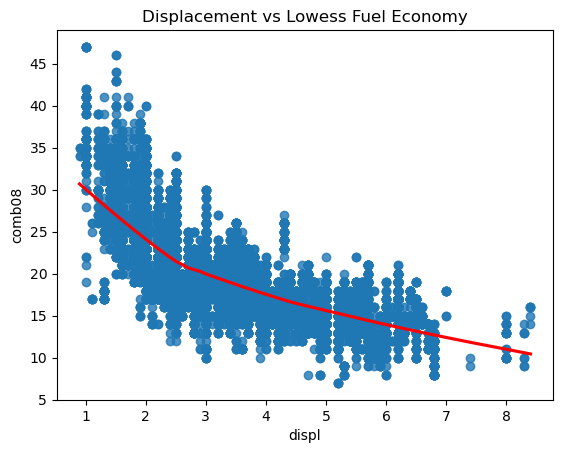

In [12]:
scatter = sns.regplot(y=train['comb08'], x=train['displ'], lowess=True, line_kws={"color": "red"})
plt.title("Displacement vs Lowess Fuel Economy");
plt.show()

In [ ]:
variables=['comb08','displ','city08','barrels08','cylinders','highway08','fuelCost08','age']
with sns.axes_style('white'):
    g=sns.pairplot(train[variables], kind='reg', 
                   plot_kws={'scatter_kws' :{'color': sns.color_palette('Blues')[-1], 'alpha': 0.4}})

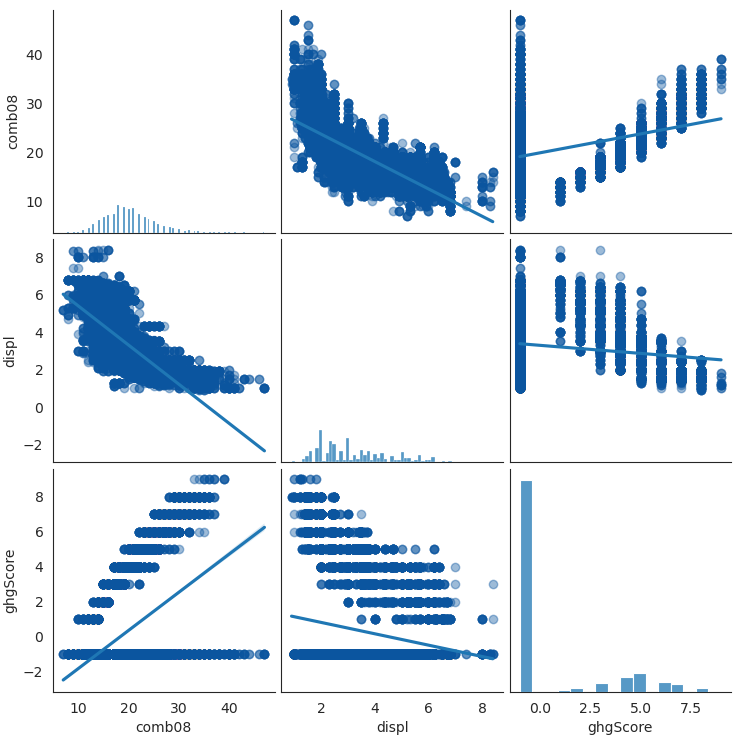

In [14]:
variables1=['comb08','displ', 'drive', 'ghgScore']
with sns.axes_style('white'):
    g=sns.pairplot(train[variables1], kind='reg', 
                   plot_kws={'scatter_kws' :{'color': sns.color_palette('Blues')[-1], 'alpha': 0.4}})

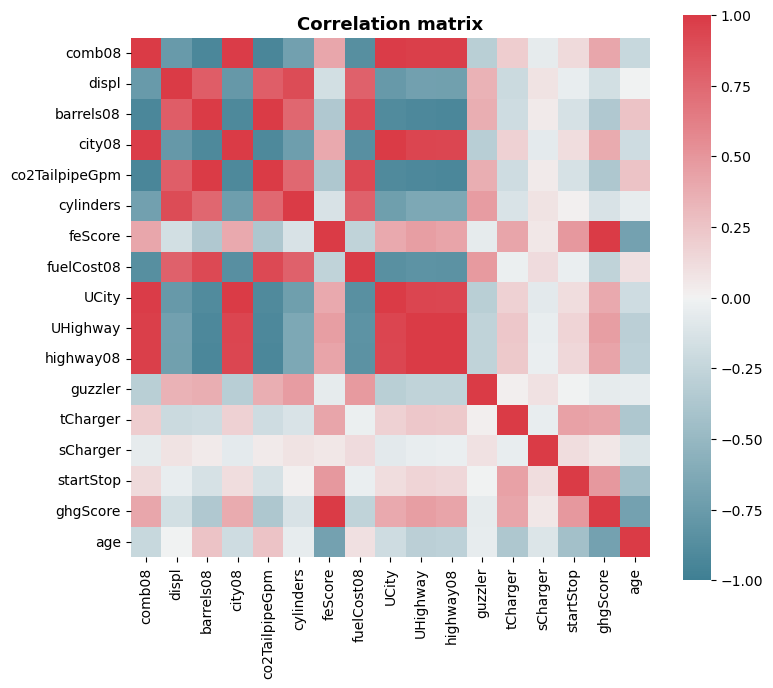

In [15]:
variables=['comb08','displ','barrels08', 'city08', 'co2TailpipeGpm','cylinders', 'drive', 'feScore', 
           'fuelCost08', 'UCity','UHighway','highway08','guzzler','tCharger','sCharger','startStop', 
           'ghgScore','trany','VClass','age']
plt.figure(figsize=(8,7))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(train[variables].corr(), vmax=1, vmin=-1, square=True, center=0, cmap=cmap) 

plt.title('Correlation matrix', fontweight='bold', fontsize=13)
plt.tight_layout()

## Variables and Model Selection
### Simple linear regression

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                 4.261e+04
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:01   Log-Likelihood:                -78257.
No. Observations:               30431   AIC:                         1.565e+05
Df Residuals:                   30429   BIC:                         1.565e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.3111      0.048    615.405      0.0

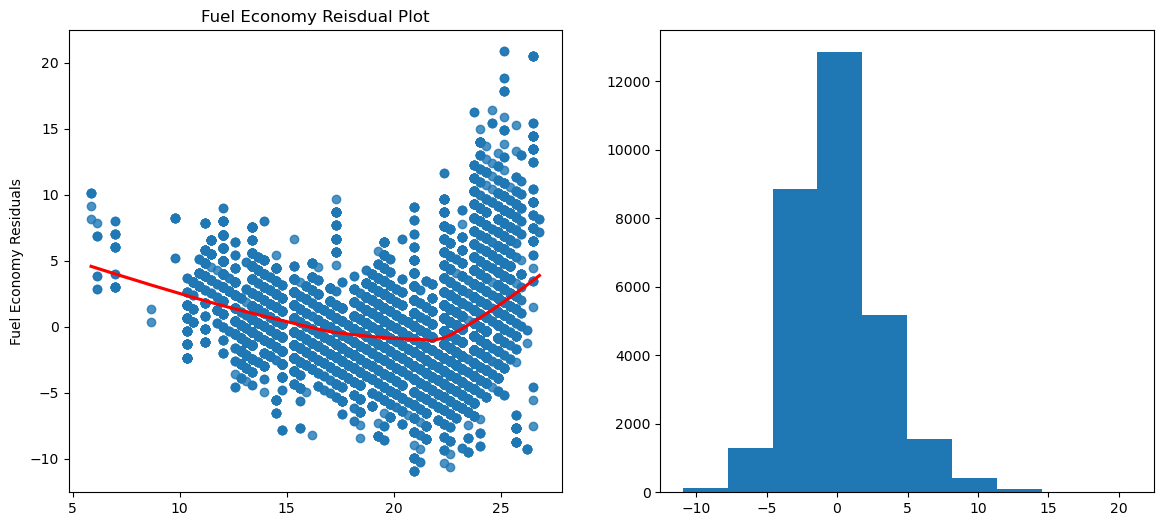

In [16]:
from statsmodels.stats.diagnostic import het_white
ols = smf.ols(formula = "comb08 ~ displ", data = train)
regression = ols.fit()

residuals = regression.resid
fitted = regression.fittedvalues

print(regression.summary())

se_regression = regression.mse_resid ** 0.5
print("\nStandard error of regression is: {}".format(se_regression))

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
residual_plot = sns.regplot(x=fitted, y=residuals, lowess=True, line_kws={"color": "red"});
plt.title("Fuel Economy Reisdual Plot")
plt.ylabel("Fuel Economy Residuals")
plt.subplot(1,2,2)
fitted_plot = plt.hist(residuals)

print("\nWhite's test p-value is: {}".format(het_white(regression.resid, regression.model.exog)[1]))

### Standard multiple linear regression

In [17]:
ols2 = smf.ols(formula = "comb08 ~ displ + city08 + cylinders", data = train).fit()
residuals2 = ols2.resid 
fitted2 = ols2.fittedvalues

print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 4.139e+05
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:01   Log-Likelihood:                -34776.
No. Observations:               30431   AIC:                         6.956e+04
Df Residuals:                   30427   BIC:                         6.959e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1998      0.045      4.446      0.0

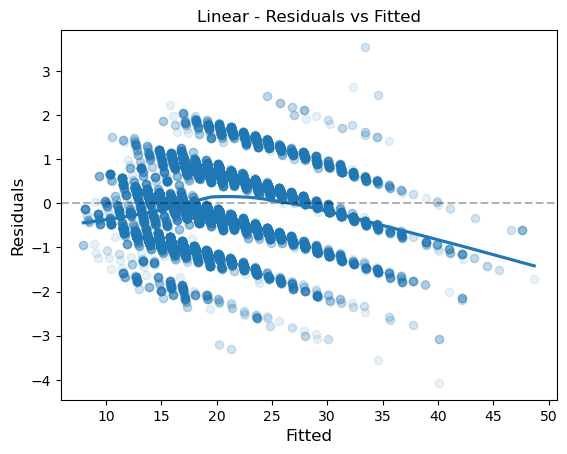

In [18]:
# MLR 3 regressor - residual plot

fig, ax = plt.subplots()
sns.regplot(x=fitted2, y=residuals2, lowess=True, ax=ax, 
            scatter_kws={'s':35, 'alpha':0.1})
ax.set_xlabel("Fitted",{'fontsize':12})
ax.set_ylabel("Residuals",{'fontsize':12})
ax.set_title('Linear - Residuals vs Fitted')
plt.axhline(color='Black', alpha=0.3, linestyle='--')
plt.show()

In [19]:
# Access the strength and goodness of fit, as well as the level of collinearity in the model
ols2.mse_resid**0.5

0.7587523726348009

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = train[['displ','city08','cylinders']]
features = sm.add_constant(features)

vif = []
for i in range (3):
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)
sum(vif)/3

[6.327890499554649, 2.5544917958214937, 5.437065876911466]


4.773149390762536

### Transforming nonlinearity and nonlinear regression
#### Log transformation

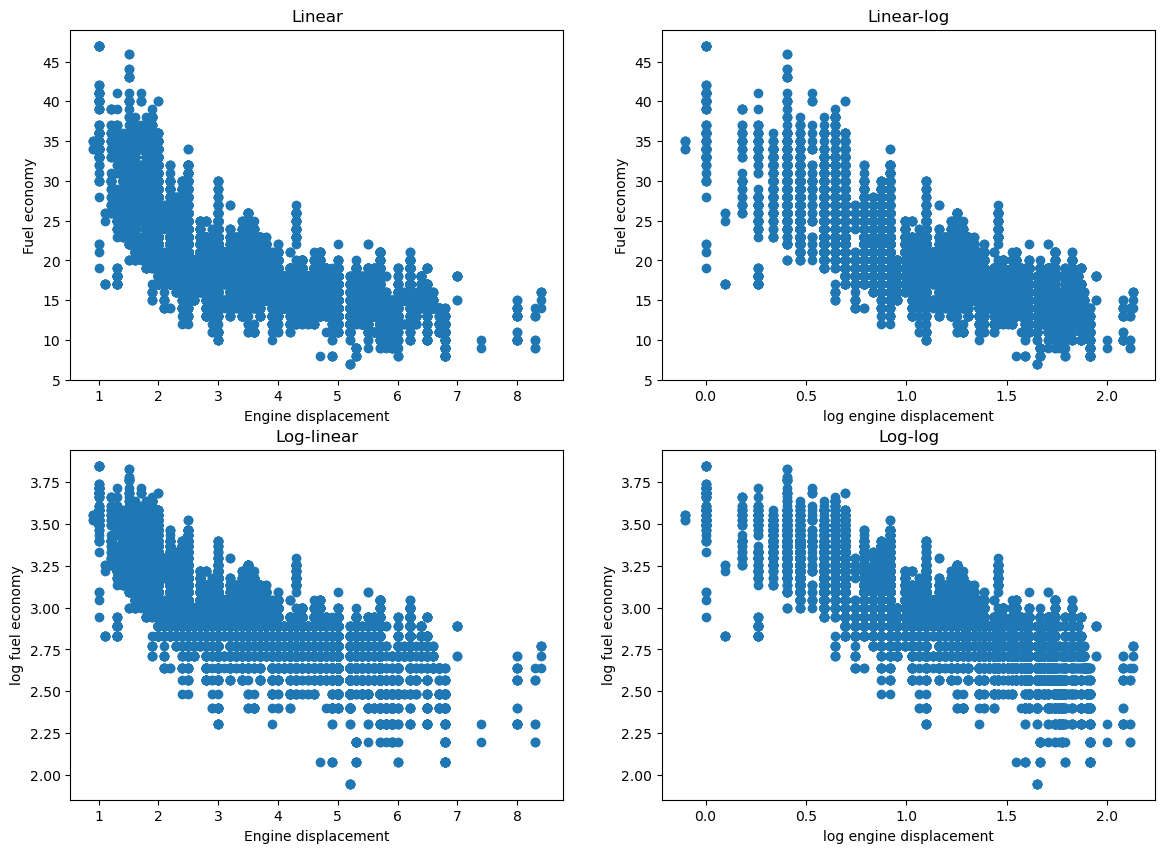

In [21]:
#Log-transformation

train['log_displ'] = np.log(train['displ'])
train['log_comb08'] = np.log(train['comb08'])
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
ax1.scatter(train['displ'],train['comb08'])
ax1.set(title='Linear', ylabel='Fuel economy', xlabel='Engine displacement')
ax2.scatter(train['log_displ'],train['comb08'])
ax2.set(title='Linear-log', ylabel='Fuel economy', xlabel='log engine displacement') #show more linear patterns
ax3.scatter(train['displ'],train['log_comb08'])
ax3.set(title='Log-linear', ylabel='log fuel economy', xlabel='Engine displacement')
ax4.scatter(train['log_displ'], train['log_comb08'])
ax4.set(title='Log-log', ylabel='log fuel economy', xlabel='log engine displacement') #show more linear patterns

#plt.savefig('Log-transformation.png')
plt.show()

In [22]:
model4 = smf.ols(formula='comb08 ~ log_displ', data=train) 
reg4 = model4.fit()
resid4 = reg4.resid
fit4 = reg4.fittedvalues
print(reg4.summary())
print(reg4.mse_resid**0.5)

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                 5.563e+04
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:02   Log-Likelihood:                -75761.
No. Observations:               30431   AIC:                         1.515e+05
Df Residuals:                   30429   BIC:                         1.515e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.7975      0.048    643.545      0.0

In [23]:
model5 = smf.ols(formula='log_comb08 ~ log_displ', data=train)
reg5 = model5.fit()
resid5 = reg5.resid
fit5 = reg5.fittedvalues
print(reg5.summary())
print(reg5.mse_resid**0.5)

                            OLS Regression Results                            
Dep. Variable:             log_comb08   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                 5.926e+04
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:02   Log-Likelihood:                 16454.
No. Observations:               30431   AIC:                        -3.290e+04
Df Residuals:                   30429   BIC:                        -3.289e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5050      0.002   1516.308      0.0

In [24]:
resid5 = reg5.resid
eres1 = np.exp(resid5) 
n = 30431

# Duan method
fp1 = sum(eres1)/n

# normal method
fp11 = np.exp(reg5.mse_resid/2)
fp1, fp11

(1.0099075809222637, 1.0099778748778356)

In [25]:
fitted5 = reg5.fittedvalues

#log-log
TS_loglog3 = np.exp(fitted5) * fp1 #Duan

res_loglog3 = train['comb08']-TS_loglog3 #Duan
print(np.sqrt(sum(res_loglog3**2)/(n-2)))
print(1 - sum(res_loglog3**2)/((n-1)*24.06993418996638)) #variance of variable 'comb08' = 24.06993418996638
print(1 - sum(res_loglog3**2)/(n-2)/24.06993418996638)

2.8623583061273514
0.6596240868798708
0.6596129009745463


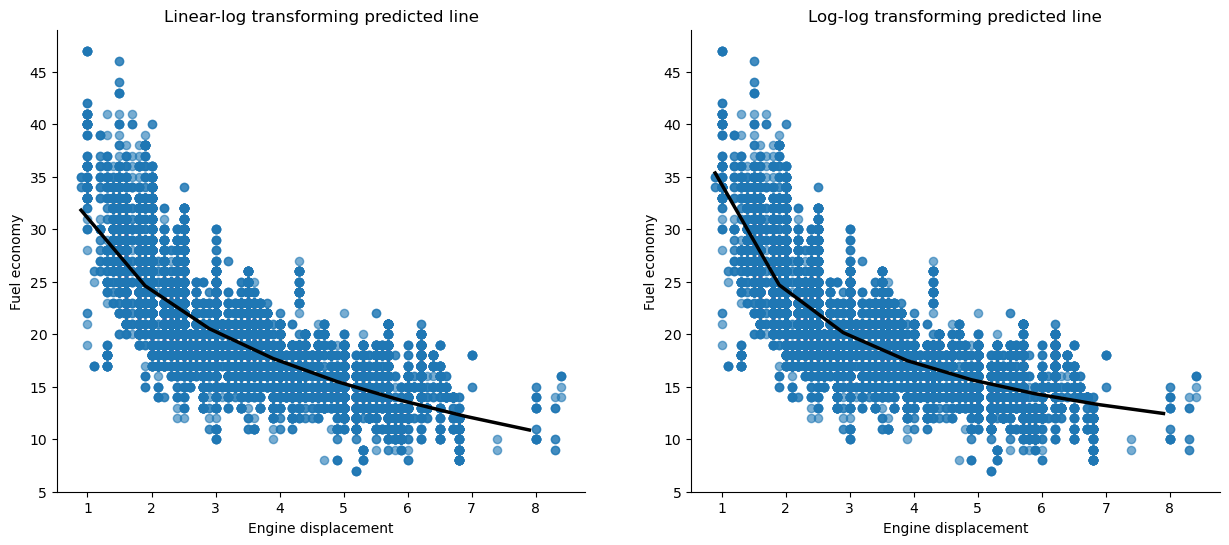

In [26]:
#log-transformation predicted line
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
sns.regplot(x=train['displ'], y=train['comb08'], ci=None, fit_reg=False, scatter_kws={'s': 35, 'alpha': 0.6})
a=train['displ'].min()
b=train['displ'].max()
x_d = np.arange(a, b)
x_ld = np.log(x_d)
TS_linlog_f = reg4.predict({'log_displ': x_ld})
ax1.plot(x_d, TS_linlog_f, color='black', linewidth=2.5)
ax1.set_xlabel('Engine displacement')
ax1.set_ylabel('Fuel economy')
ax1.set_title(r'Linear-log transforming predicted line')
sns.despine()

ax2 = fig.add_subplot(1,2,2)
sns.regplot(x=train['displ'], y=train['comb08'], ci=None, fit_reg=False, scatter_kws={'s': 35, 'alpha': 0.6})
a1=train['displ'].min()
b1=train['displ'].max()
x1=np.linspace(a1, b1)
x_d1 = np.arange(a1, b1)
x_ld1 = np.log(x_d1)
logTS_loglog = reg5.predict({'log_displ': x_ld1}) 
TS_loglog_f = np.exp(logTS_loglog) * fp1
ax2.plot(x_d, TS_loglog_f, color='black', linewidth=2.5)
ax2.set_xlabel('Engine displacement')
ax2.set_ylabel('Fuel economy')
ax2.set_title(r'Log-log transforming predicted line')
sns.despine()

#plt.savefig('Log transformation 1.png')
plt.show()

#### Polynomial regression

In [27]:
formula='comb08 ~ displ + np.power(displ, 2)'
ols6 = smf.ols(formula=formula, data=train).fit()
resid6 = ols6.resid
fitted6 = ols6.fittedvalues
print(ols6.summary())
print(ols6.mse_resid**0.5)

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                 2.751e+04
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:02   Log-Likelihood:                -75868.
No. Observations:               30431   AIC:                         1.517e+05
Df Residuals:                   30428   BIC:                         1.518e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             36.8119      0

In [28]:
formula='comb08 ~ displ + np.power(displ, 2) + np.power(displ, 3)'
ols7 = smf.ols(formula=formula, data=train).fit()
resid7 = ols7.resid
fitted7 = ols7.fittedvalues
print(ols7.summary())
print(ols7.mse_resid**0.5)

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                 1.920e+04
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:02   Log-Likelihood:                -75415.
No. Observations:               30431   AIC:                         1.508e+05
Df Residuals:                   30427   BIC:                         1.509e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             43.4716      0

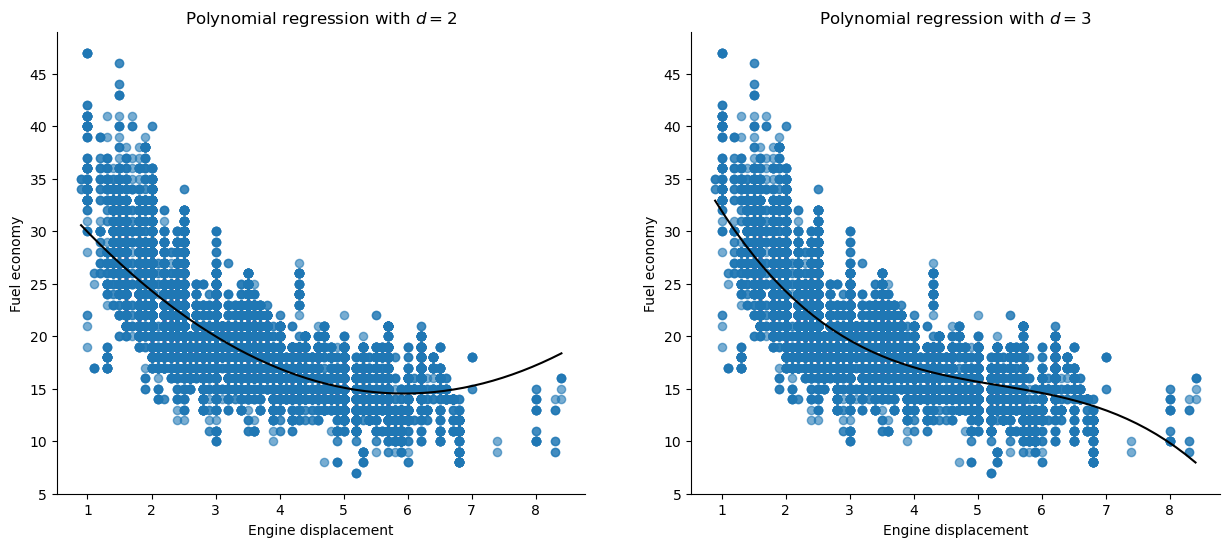

In [29]:
#polynomial regression fitted line
a=train['displ'].min()
b=train['displ'].max()
x=np.linspace(a, b)

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
sns.regplot(x= train['displ'], y=train['comb08'], ci=None, fit_reg=False, scatter_kws={'s': 35, 'alpha': 0.6})
y=ols6.predict({'displ': x})
ax1.plot(x, y, color='black')
ax1.set_xlabel('Engine displacement')
ax1.set_ylabel('Fuel economy')
ax1.set_title(r'Polynomial regression with $d=2$')
sns.despine()

ax2 = fig.add_subplot(1,2,2)
sns.regplot(x=train['displ'], y=train['comb08'], ci=None, fit_reg=False, scatter_kws={'s': 35, 'alpha': 0.6})
y1=ols7.predict({'displ': x})
ax2.plot(x, y1, color='black')
ax2.set_xlabel('Engine displacement')
ax2.set_ylabel('Fuel economy')
ax2.set_title(r'Polynomial regression with $d=3$')
sns.despine()

#plt.savefig('Polynomial regression.png')
plt.show()

### Interaction effect

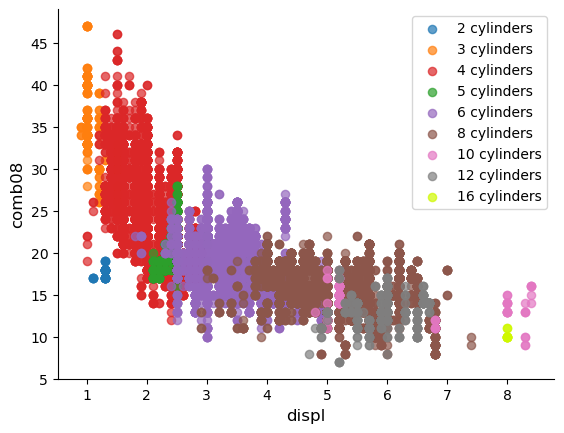

In [30]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f','#cff800']
fig, ax= plt.subplots() 
index=(train['cylinders']==2)
sns.regplot(x= train.loc[index, 'displ'], y=train.loc[index, 'comb08'], label='2 cylinders', ci=None, 
            fit_reg=False, scatter_kws={'s': 35, 'color': tableau[0], 'alpha': 0.7})

index=(train['cylinders']==3)
sns.regplot(x=train.loc[index, 'displ'], y=train.loc[index, 'comb08'], label='3 cylinders', ci=None, 
            fit_reg=False, scatter_kws={'s': 35, 'color': tableau[1], 'alpha': 0.7})

index=(train['cylinders']==4)
sns.regplot(x=train.loc[index, 'displ'], y=train.loc[index, 'comb08'], label='4 cylinders', ci=None, 
            fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})

index=(train['cylinders']==5)
sns.regplot(x=train.loc[index, 'displ'], y=train.loc[index, 'comb08'], label='5 cylinders', ci=None, 
            fit_reg=False, scatter_kws={'s': 35, 'color': tableau[2], 'alpha': 0.7})

index=(train['cylinders']==6)
sns.regplot(x=train.loc[index, 'displ'], y=train.loc[index, 'comb08'], label='6 cylinders', ci=None, 
            fit_reg=False, scatter_kws={'s': 35, 'color': tableau[4], 'alpha': 0.7})

index=(train['cylinders']==8)
sns.regplot(x=train.loc[index, 'displ'], y=train.loc[index, 'comb08'], label='8 cylinders', ci=None, 
            fit_reg=False, scatter_kws={'s': 35, 'color': tableau[5], 'alpha': 0.7})

index=(train['cylinders']==10)
sns.regplot(x=train.loc[index, 'displ'], y=train.loc[index, 'comb08'], label='10 cylinders', ci=None, 
            fit_reg=False, scatter_kws={'s': 35, 'color': tableau[6], 'alpha': 0.7})

index=(train['cylinders']==12)
sns.regplot(x=train.loc[index, 'displ'], y=train.loc[index, 'comb08'], label='12 cylinders', ci=None, 
            fit_reg=False, scatter_kws={'s': 35, 'color': tableau[7], 'alpha': 0.7})

index=(train['cylinders']==16)
sns.regplot(x=train.loc[index, 'displ'], y=train.loc[index, 'comb08'], label='16 cylinders', ci=None, 
            fit_reg=False, scatter_kws={'s': 35, 'color': tableau[8], 'alpha': 0.7})

a=ax.get_xlim()[0]
b=ax.get_xlim()[1]
x=np.arange(a, b, 0.1)
plt.legend(loc='best')
ax.set_xlabel('displ',  {'fontsize': 12})
ax.set_ylabel('comb08', {'fontsize': 12})
sns.despine()
#plt.savefig('Interaction.png')
plt.show()

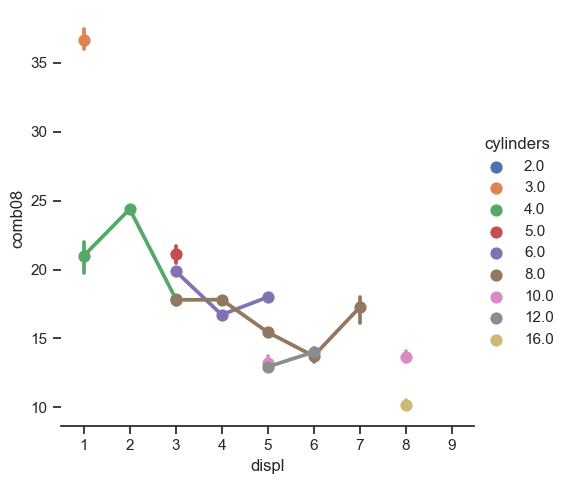

In [31]:
#interaction effect between cylinders and displ 
sns.set(style="ticks")
g1 = sns.catplot(x="displ", y="comb08", hue="cylinders", order = [1,2,3,4,5,6,7,8,9], data=train, kind="point") #, size=5, aspect=.8)
g1.despine(left=True)
plt.show()

In [32]:
ols8 = smf.ols(formula='comb08 ~ displ + cylinders + displ:cylinders', data=train) 
reg8 = ols8.fit()
print(reg8.summary())
print(reg8.mse_resid**0.5)

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                 1.702e+04
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:04   Log-Likelihood:                -76589.
No. Observations:               30431   AIC:                         1.532e+05
Df Residuals:                   30427   BIC:                         1.532e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          38.5587      0.162    2

In [33]:
table = sm.stats.anova_lm(reg8, typ=3)
print(table)

                        sum_sq       df             F  PR(>F)
Intercept        508224.003866      1.0  56547.469077     0.0
displ             80546.068477      1.0   8961.946468     0.0
cylinders         26603.305882      1.0   2960.012918     0.0
displ:cylinders   29802.559178      1.0   3315.977366     0.0
Residual         273464.613326  30427.0           NaN     NaN


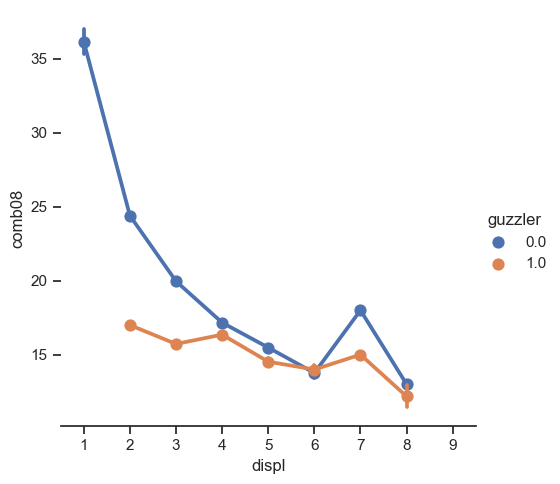

In [34]:
sns.set(style="ticks")
g1 = sns.catplot(x="displ", y="comb08", hue="guzzler", order = [1,2,3,4,5,6,7,8,9],data=train, kind="point") #, size=5, aspect=.8)
g1.despine(left=True)
plt.show()

### Other potential models 

In [35]:
#the optimal model without interaction term and with categorial variables 
ols9 = smf.ols(formula='comb08 ~ log_displ + city08 + highway08 + cylinders + age + C(fuelType)', data=train) #good model for the causal model for fuel economy
reg9 = ols9.fit()
resid9 = reg9.resid
fit9 = reg9.fittedvalues
print(reg9.summary())
print(reg9.mse_resid**0.5)

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 6.990e+05
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:04   Log-Likelihood:                -12164.
No. Observations:               30431   AIC:                         2.435e+04
Df Residuals:                   30422   BIC:                         2.442e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [36]:
# 2 regressors model
ols10 = smf.ols(formula = 'comb08 ~ city08 + highway08',data = train)
reg10 = ols10.fit()
fit10 = reg10.fittedvalues
resid10 = reg10.resid
print(reg10.summary())
print(reg10.mse_resid**0.5)

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.774e+06
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:04   Log-Likelihood:                -12286.
No. Observations:               30431   AIC:                         2.458e+04
Df Residuals:                   30428   BIC:                         2.460e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0682      0.009     -7.571      0.0

In [37]:
# 3 regressors model 
ols11 = smf.ols(formula = 'comb08 ~ displ + city08 + cylinders',data = train)
reg11 = ols11.fit()
fit11 = reg11.fittedvalues
resid11 = reg11.resid
print(reg11.summary())
print(reg11.mse_resid**0.5)

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 4.139e+05
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:04   Log-Likelihood:                -34776.
No. Observations:               30431   AIC:                         6.956e+04
Df Residuals:                   30427   BIC:                         6.959e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1998      0.045      4.446      0.0

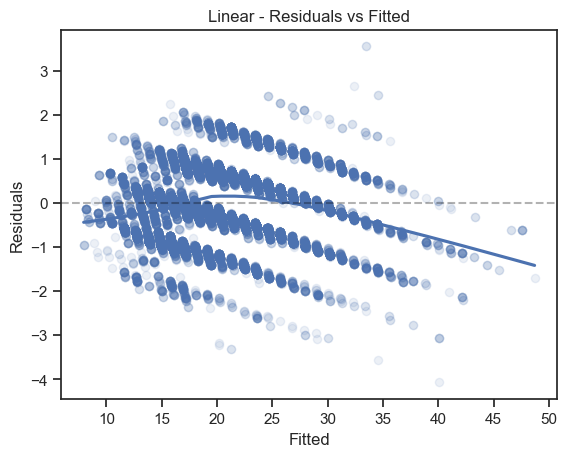

In [38]:
#MLR 3 regressor - residual plot
fig, ax= plt.subplots()
sns.regplot(x=fit11, y=resid11, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': 0.1})
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Linear - Residuals vs Fitted')
plt.axhline(color='Black', alpha=0.3, linestyle='--')
plt.savefig('MLR-3.png')
plt.show() #still show non-linear pattern in here 

### Forward selection and MLR models

In [39]:
def forward_selected(data, response, nominated = []):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    selected = nominated
    remaining.remove(response)
    remaining ^= set(selected)
    current_score, best_new_score = 0.0, 0.0
    if nominated:
        formula = "{} ~ {} + 1".format(response, ' + '.join(nominated))
        current_score= smf.ols(formula, data).fit().rsquared_adj
        best_new_score = current_score
        print("you nominated variable(s) %s, the adj_r2 is: %f" %(nominated, current_score))
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("adding %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

In [40]:
variables=['comb08','displ','barrels08', 'UCity', 'co2TailpipeGpm','cylinders', 'drive', 'feScore', 'fuelCost08', 
           'city08','UHighway','highway08','guzzler','tCharger','sCharger','startStop', 'ghgScore',
           'trany','VClass','age','fuelType']
model = forward_selected(train[variables], 'comb08', nominated=[])

adding UCity increases adj_r2 from 0.000000 to 0.975545
adding highway08 increases adj_r2 from 0.975545 to 0.995109
adding barrels08 increases adj_r2 from 0.995109 to 0.995818
adding city08 increases adj_r2 from 0.995818 to 0.995963
adding co2TailpipeGpm increases adj_r2 from 0.995963 to 0.996054
adding fuelType increases adj_r2 from 0.996054 to 0.996376
adding VClass increases adj_r2 from 0.996376 to 0.996394
adding ghgScore increases adj_r2 from 0.996394 to 0.996406
adding displ increases adj_r2 from 0.996406 to 0.996415
adding drive increases adj_r2 from 0.996415 to 0.996419
adding trany increases adj_r2 from 0.996419 to 0.996424
adding feScore increases adj_r2 from 0.996424 to 0.996427
adding UHighway increases adj_r2 from 0.996427 to 0.996430
adding tCharger increases adj_r2 from 0.996430 to 0.996432
adding age increases adj_r2 from 0.996432 to 0.996433
adding guzzler increases adj_r2 from 0.996433 to 0.996434
adding sCharger increases adj_r2 from 0.996434 to 0.996434
final model 

In [41]:
#full model 
ols12 = smf.ols(formula='comb08 ~ tCharger + UCity + displ + sCharger + city08 + startStop + trany + age + feScore + barrels08 + VClass + drive + UHighway + highway08 + ghgScore + co2TailpipeGpm + fuelType', data=train) #ols
reg12 = ols12.fit()
fit12 = reg12.fittedvalues
resid12 = reg12.resid
print(reg12.summary())
print(reg12.mse_resid**0.5)

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.501e+05
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:29   Log-Likelihood:                -5522.3
No. Observations:               29552   AIC:                         1.116e+04
Df Residuals:                   29496   BIC:                         1.162e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

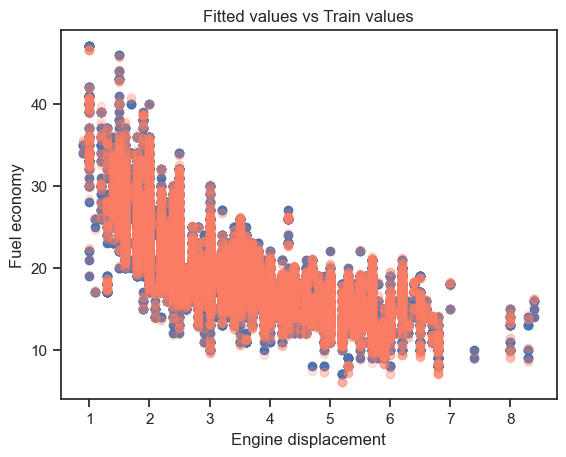

In [42]:
#MLR 17 regressors fitted values

data_common1 = train['comb08'].index.intersection(fit12.index)

tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f',
         '#cff800','#ffd481','#FF8164']
fig, ax= plt.subplots()
ax.set_xlabel('Engine displacement',  {'fontsize': 12})
ax.set_ylabel('Fuel economy', {'fontsize': 12})
plt.scatter(train.loc[data_common1,'displ'], train.loc[data_common1,'comb08'])
plt.scatter(train.loc[data_common1,'displ'], fit12, color = tableau[10], alpha = 0.2)

plt.title('Fitted values vs Train values')

plt.show()

In [43]:
variables1=['comb08','displ','barrels08', 'city08','cylinders', 'drive', 'fuelCost08','highway08','guzzler',
            'tCharger','sCharger','startStop', 'ghgScore','trany','VClass','age','fuelType']
model1 = forward_selected(train[variables1], 'comb08', nominated=[])

adding city08 increases adj_r2 from 0.000000 to 0.975419
adding highway08 increases adj_r2 from 0.975419 to 0.994545
adding barrels08 increases adj_r2 from 0.994545 to 0.994720
adding VClass increases adj_r2 from 0.994720 to 0.994738
adding fuelType increases adj_r2 from 0.994738 to 0.994754
adding ghgScore increases adj_r2 from 0.994754 to 0.994773
adding startStop increases adj_r2 from 0.994773 to 0.994776
adding guzzler increases adj_r2 from 0.994776 to 0.994780
adding age increases adj_r2 from 0.994780 to 0.994783
adding displ increases adj_r2 from 0.994783 to 0.994786
adding trany increases adj_r2 from 0.994786 to 0.994787
adding tCharger increases adj_r2 from 0.994787 to 0.994788
adding cylinders increases adj_r2 from 0.994788 to 0.994789
adding fuelCost08 increases adj_r2 from 0.994789 to 0.994789
final model is comb08 ~ city08 + highway08 + barrels08 + VClass + fuelType + ghgScore + startStop + guzzler + age + displ + trany + tCharger + cylinders + fuelCost08 + 1, with adj_r2 o

In [44]:
#14 regressors
ols13 = smf.ols(formula='comb08 ~ city08 + highway08 + barrels08 + VClass + fuelType + ghgScore + startStop + guzzler + age + displ + trany + tCharger + cylinders + fuelCost08', data=train) #good model for the causal model for fuel economy
reg13 = ols13.fit()
fit13 = reg13.fittedvalues
resid13 = reg13.resid
print(reg13.summary())
print(reg13.mse_resid**0.5)

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.236e+05
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:45   Log-Likelihood:                -11569.
No. Observations:               30431   AIC:                         2.323e+04
Df Residuals:                   30383   BIC:                         2.363e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

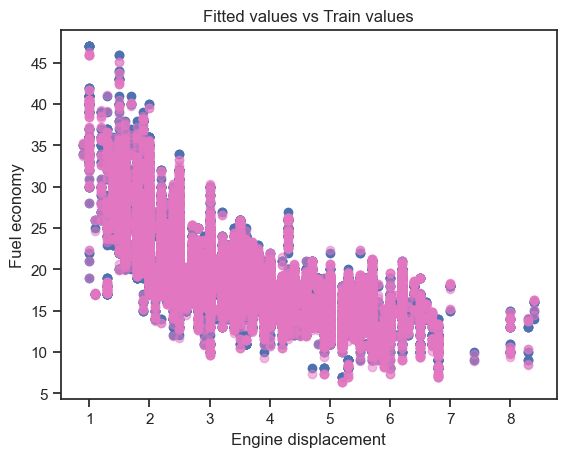

In [45]:
#14 regressors fitted values

fig, ax= plt.subplots()
ax.set_xlabel('Engine displacement',  {'fontsize': 12})
ax.set_ylabel('Fuel economy', {'fontsize': 12})
plt.scatter(train['displ'], train['comb08'])
plt.scatter(train['displ'], fit13, color = tableau[6], alpha = 0.5)

plt.title('Fitted values vs Train values')

plt.show()

### Simpler models

In [46]:
# 6 regressors model
train['log_displ'] = np.log(train['displ'])
ols14 = smf.ols(formula='comb08 ~ log_displ + city08 + highway08 + cylinders + cylinders:log_displ + age + C(fuelType)', data=train) #good model for the causal model for fuel economy
reg14 = ols14.fit()
resid14 = reg14.resid
fit14 = reg14.fittedvalues
print(reg14.summary())
print(reg14.mse_resid**0.5)

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 6.226e+05
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:45   Log-Likelihood:                -12133.
No. Observations:               30431   AIC:                         2.429e+04
Df Residuals:                   30421   BIC:                         2.437e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

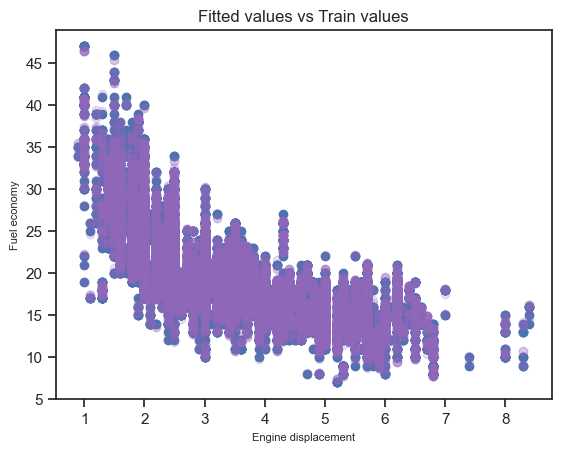

In [47]:
#6 regressors fitted values

fig, ax= plt.subplots()
ax.set_xlabel('Engine displacement',  {'fontsize': 8})
ax.set_ylabel('Fuel economy', {'fontsize': 8})
plt.scatter(train['displ'], train['comb08'])
plt.scatter(train['displ'], fit14, color = tableau[4], alpha = 0.2)

plt.title('Fitted values vs Train values')

plt.show()

In [48]:
#MLR with 6 predictors (log-log transformation)

ols15 = smf.ols(formula='log_comb08 ~ log_displ + city08 + highway08 + cylinders + cylinders:log_displ + age + C(fuelType)', data=train) #good model for the causal model for fuel economy
reg15 = ols15.fit()
resid15 = reg15.resid
fit15 = reg15.fittedvalues
print(reg15.summary())
print(reg15.mse_resid**0.5)

                            OLS Regression Results                            
Dep. Variable:             log_comb08   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 1.357e+05
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:18:45   Log-Likelihood:                 56568.
No. Observations:               30431   AIC:                        -1.131e+05
Df Residuals:                   30421   BIC:                        -1.130e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [49]:
eres15 = np.exp(resid15) 
n = 30431

# Duan method
fp15 = sum(eres15)/n

# normal method
fp111 = np.exp(reg15.mse_resid/2)
fp15, fp111

(1.0006977294680266, 1.0007115010864076)

In [50]:
#log-log
TS_loglog111 = np.exp(fit15)
TS_loglog112 = np.exp(fit15) * fp15 #Duan
TS_loglog113 = np.exp(fit15) * fp111 #normal

In [51]:
res_loglog11 = train['comb08']-TS_loglog111
print(np.sqrt(sum(res_loglog11**2)/(n-2)))
print(1 - sum(res_loglog11**2)/((n-1)*24.06993418996638))
print(1 - sum(res_loglog11**2)/(n-2)/24.06993418996638)

0.8544858675571736
0.9696666348230352
0.9696656379659193


In [52]:
res_loglog3 = train['comb08']-TS_loglog112 #Duan
print(np.sqrt(sum(res_loglog3**2)/(n-2)))
print(1 - sum(res_loglog3**2)/((n-1)*24.06993418996638)) 
print(1 - sum(res_loglog3**2)/(n-2)/24.06993418996638)

0.8560617878850271
0.9695546445610672
0.9695536440235721


In [53]:
res_loglog31 = train['comb08']-TS_loglog113 #normal
print(np.sqrt(sum(res_loglog31**2)/(n-2)))
print(1 - sum(res_loglog31**2)/((n-1)*24.06993418996638)) 
print(1 - sum(res_loglog31**2)/(n-2)/24.06993418996638)

0.8560953581538217
0.9695522566988358
0.9695512560828674


### Residual plots

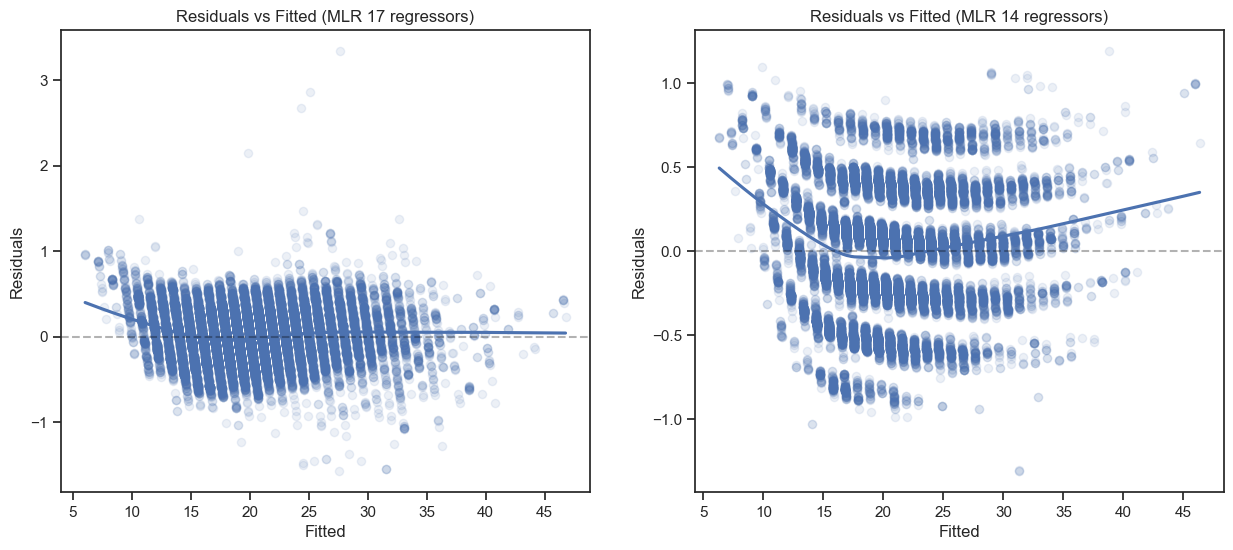

In [54]:
#residual plot MLR 17 & 14 regressors
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
sns.regplot(x=fit12, y=resid12, lowess=True, ax=ax1, scatter_kws={'s': 35, 'alpha': 0.1})
ax1.set_xlabel('Fitted',  {'fontsize': 12})
ax1.set_ylabel('Residuals', {'fontsize': 12})
ax1.set_title('Residuals vs Fitted (MLR 17 regressors)')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  

ax2 = fig.add_subplot(1,2,2)
sns.regplot(x=fit13, y=resid13, lowess=True, ax=ax2, scatter_kws={'s': 35, 'alpha': 0.1})
ax2.set_xlabel('Fitted',  {'fontsize': 12})
ax2.set_ylabel('Residuals', {'fontsize': 12})
ax2.set_title('Residuals vs Fitted (MLR 14 regressors)')
plt.axhline(color='Black', alpha=0.3, linestyle='--')

plt.show() #still show non-linear pattern in here 

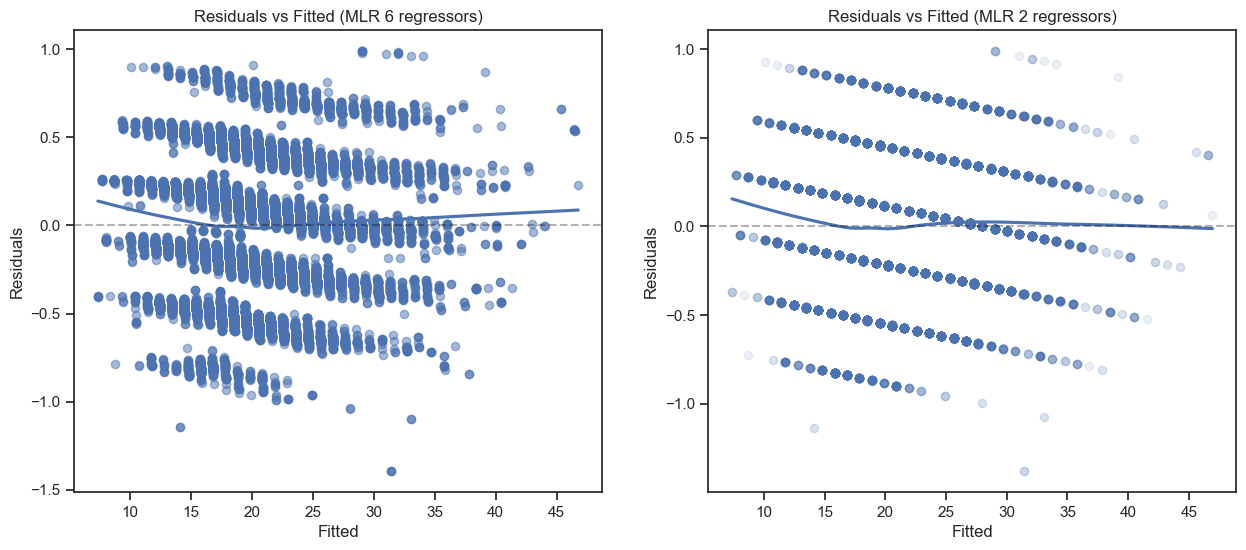

In [55]:
#residual plot - MLR 6 & 2 regessors
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
sns.regplot(x=fit14, y=resid14, lowess=True, ax=ax1, scatter_kws={'s': 35, 'alpha': 0.5})
ax1.set_xlabel('Fitted',  {'fontsize': 12})
ax1.set_ylabel('Residuals', {'fontsize': 12})
ax1.set_title('Residuals vs Fitted (MLR 6 regressors)')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  

ax2 = fig.add_subplot(1,2,2)
sns.regplot(x=fit10, y=resid10, lowess=True, ax=ax2, scatter_kws={'s': 35, 'alpha': 0.1})
ax2.set_xlabel('Fitted',  {'fontsize': 12})
ax2.set_ylabel('Residuals', {'fontsize': 12})
ax2.set_title('Residuals vs Fitted (MLR 2 regressors)')
plt.axhline(color='Black', alpha=0.3, linestyle='--')

plt.show() #still show non-linear pattern in here 

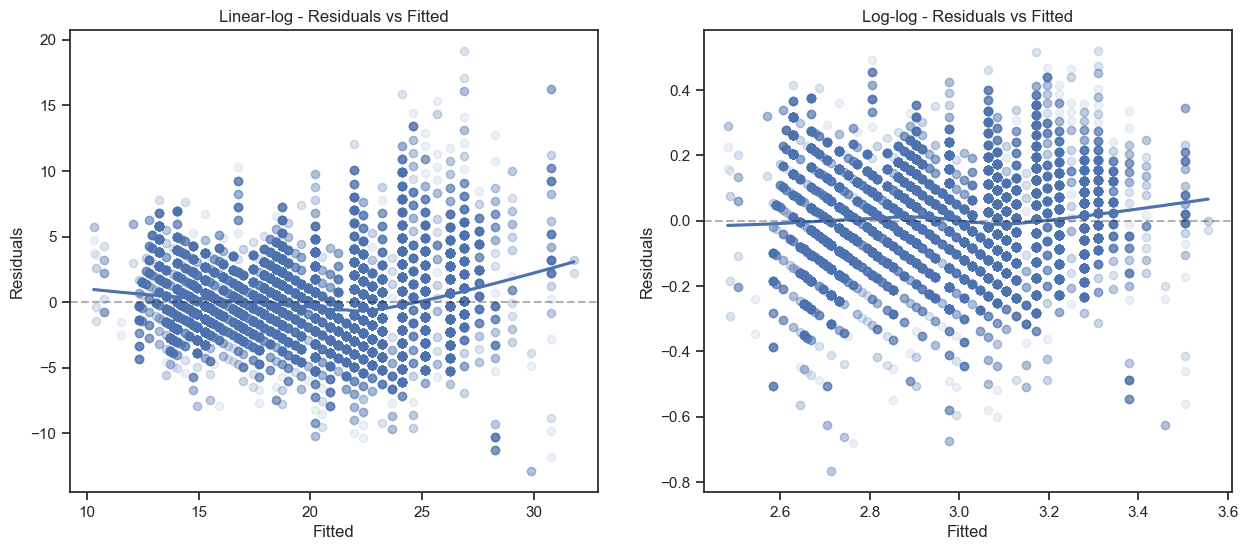

In [56]:
#residual plot - log-transformation
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
sns.regplot(x=fit4, y=resid4, lowess=True, ax=ax1, scatter_kws={'s': 35, 'alpha': 0.1})
ax1.set_xlabel('Fitted',  {'fontsize': 12})
ax1.set_ylabel('Residuals', {'fontsize': 12})
ax1.set_title('Linear-log - Residuals vs Fitted')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  

ax2 = fig.add_subplot(1,2,2)
sns.regplot(x=fit5, y=resid5, lowess=True, ax=ax2, scatter_kws={'s': 35, 'alpha': 0.1})
ax2.set_xlabel('Fitted',  {'fontsize': 12})
ax2.set_ylabel('Residuals', {'fontsize': 12})
ax2.set_title('Log-log - Residuals vs Fitted')
plt.axhline(color='Black', alpha=0.3, linestyle='--') 

plt.show()

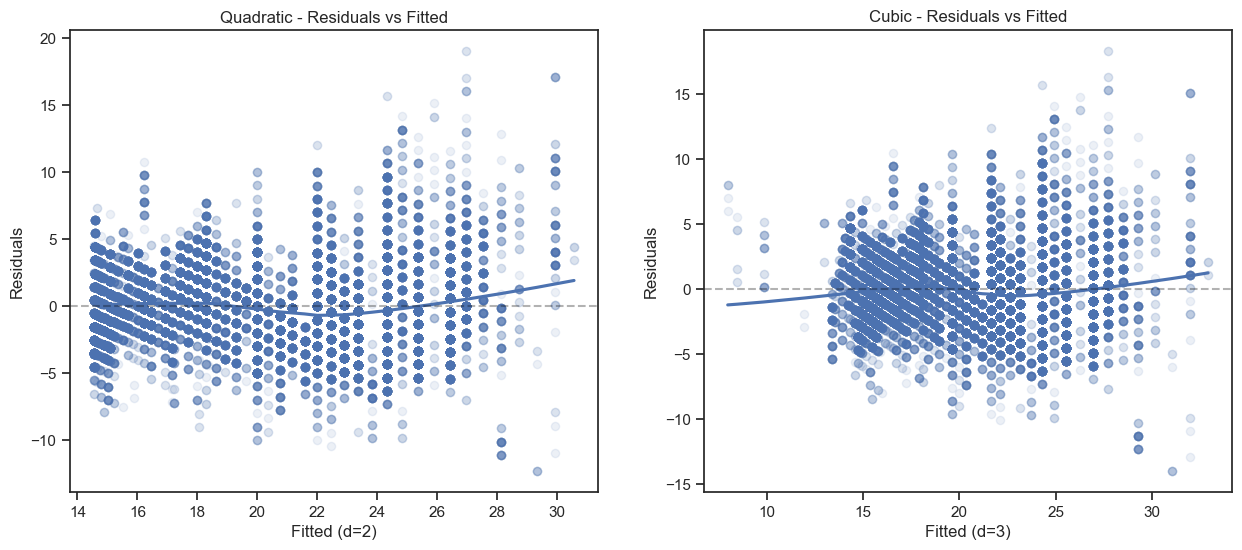

In [57]:
#residual plot - quadratic & cubic
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
sns.regplot(x=fitted6, y=resid6, lowess=True, ax=ax1, scatter_kws={'s': 35, 'alpha': 0.1})
ax1.set_xlabel('Fitted (d=2)',  {'fontsize': 12})
ax1.set_ylabel('Residuals', {'fontsize': 12})
ax1.set_title('Quadratic - Residuals vs Fitted')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  

ax2 = fig.add_subplot(1,2,2)
sns.regplot(x=fitted7, y=resid7, lowess=True, ax=ax2, scatter_kws={'s': 35, 'alpha': 0.1})
ax2.set_xlabel('Fitted (d=3)',  {'fontsize': 12})
ax2.set_ylabel('Residuals', {'fontsize': 12})
ax2.set_title('Cubic - Residuals vs Fitted')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  

plt.show()

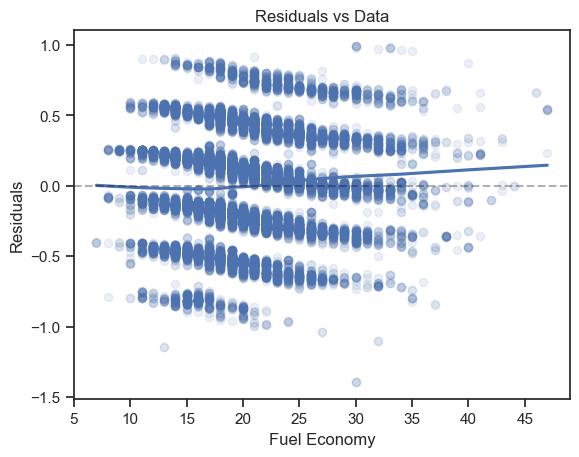

In [58]:
#MLR 6 regressor 
fig, ax= plt.subplots()
sns.regplot(x=train['comb08'], y=resid14, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': 0.1})
ax.set_xlabel('Fuel Economy',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Data')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.savefig('Residual plot (MLR 6).png')
plt.show()

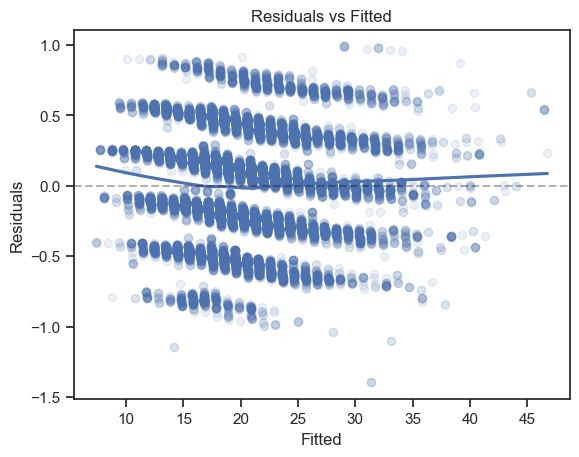

In [59]:
#MLR 6 regressor 
fig, ax= plt.subplots()
sns.regplot(x=fit14, y=resid14, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': 0.1})
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.savefig('Residual plot (MLR 6).png')
plt.show()

### VIF Calculation

In [60]:
#VIF for 6 models
features2 = train[['log_displ','city08','age','highway08','cylinders']]
features2 = sm.add_constant(features2)  

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif2 = []
for i in range(5):
    vif2.append(variance_inflation_factor(features2.values, i+1)) 
    
print(vif2) 
print(sum(vif2)/5)

[6.821782645278037, 11.624890703179808, 1.253524428027715, 9.19906168858619, 4.778440502698965]
6.735539993554143


In [61]:
#VIF calculation - 17 model
features = train[['city08','highway08','tCharger','UCity','displ','sCharger','startStop','age','feScore','barrels08', 'UHighway','ghgScore','co2TailpipeGpm']]
features = sm.add_constant(features)  

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(13):
    vif.append(variance_inflation_factor(features.values, i+1)) 
    
print(vif) 
print(sum(vif)/13) 

[184.79787916589436, 134.3324929452852, 1.5346844378251518, 181.7435040254065, 4.181053370102257, 1.051176111368174, 1.512682139177857, 2.395887042563413, 1233.0739352513938, 623.7755897739727, 147.0236607332641, 1226.3169684894456, 637.610251924776]
336.87305887772885


In [62]:
#VIF calculation - 14 model
features2 = train[['city08','highway08','tCharger','displ','sCharger','startStop','age','barrels08','ghgScore','cylinders','guzzler']]
features2 = sm.add_constant(features2)  

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif2 = []
for i in range(11):
    vif2.append(variance_inflation_factor(features2.values, i+1)) 
    
print(vif2) 
print(sum(vif2)/11) 

[11.59704996341357, 13.761427115530951, 1.505413486250694, 7.781541242251299, 1.0502622858144597, 1.5221052572608906, 2.4017519617279204, 11.535993258891136, 2.605730325992341, 6.654575117944826, 1.3953316304338206]
5.619198331410174


In [63]:
#VIF calculation - 2 model
features1 = train[['city08','highway08']]
features1 = sm.add_constant(features1)  

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif1 = []
for i in range(2):
    vif1.append(variance_inflation_factor(features1.values, i+1)) 
    
print(vif1) 

[8.20138355335371, 8.20138355335371]


### Diagnostic analysis

In [64]:
from scipy.stats import f_oneway
from statsmodels.stats.anova import anova_lm

In [65]:
print(anova_lm(reg14))

                          df         sum_sq        mean_sq             F  \
C(fuelType)              3.0   17107.669566    5702.556522  4.386347e+04   
log_displ                1.0  486157.122632  486157.122632  3.739470e+06   
city08                   1.0  212676.492824  212676.492824  1.635886e+06   
highway08                1.0   12533.594370   12533.594370  9.640711e+04   
cylinders                1.0       0.087514       0.087514  6.731519e-01   
cylinders:log_displ      1.0       6.857940       6.857940  5.275057e+01   
age                      1.0      11.331151      11.331151  8.715804e+01   
Residual             30421.0    3954.941403       0.130007           NaN   

                           PR(>F)  
C(fuelType)          0.000000e+00  
log_displ            0.000000e+00  
city08               0.000000e+00  
highway08            0.000000e+00  
cylinders            4.119613e-01  
cylinders:log_displ  3.877970e-13  
age                  1.067801e-20  
Residual                   

## Out-of-sample forecast

In [66]:
# forecast with 6 regressors model
test['log_displ'] = np.log(test['displ'])
yp_6 = reg14.predict(test)
print(yp_6)

0        21.263050
1        10.756503
2        24.636510
3        13.089962
4        21.599372
           ...    
10139    20.856083
10140    22.906785
10141    21.599372
10142    20.960072
10143    24.309284
Length: 10144, dtype: float64


In [67]:
data_common = test['comb08'].index.intersection(yp_6.index)
#RMSFE - root square of MSFE
rmse = (np.sum((test.loc[data_common,'comb08'] - yp_6)**2)/len(yp_6))**0.5
print(rmse)

#MAD 
mafe = np.sum(abs(test.loc[data_common,'comb08'] - yp_6))/len(yp_6)
print(mafe)

0.354863729054051
0.293665390822711


In [68]:
formula='comb08 ~ yp_6'
ols_6 = smf.ols(formula=formula, data=test.loc[data_common]).fit()
ols_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 comb08   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.946e+06
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:19:27   Log-Likelihood:                -3884.2
No. Observations:               10143   AIC:                             7772.
Df Residuals:                   10141   BIC:                             7787.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0007      0.015      0.050      0.960      -0.028       0.030
yp_6           0.9999      0.001   1395.086      0.000       0.998       1.001
==============================================================================
Omnibus:                      236.013   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.023
Skew:                          -0.056   Prob(JB):                     7.10e-28
Kurtosis:                       2.468   Cond. No.                         87.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
# forecast with 13 regressors model - without VClass - 
ols16 = smf.ols(formula='comb08 ~ city08 + highway08 + barrels08 + fuelType + ghgScore + startStop + guzzler + age + displ + trany + tCharger + cylinders + fuelCost08', data=train) 
reg16 = ols16.fit()

yp_13 = reg16.predict(test)

common = test['comb08'].index.intersection(yp_13.index)

#RMSFE - root square of MSFE
rmse = (np.sum((test.loc[common,'comb08'] - yp_13)**2)/len(yp_13))**0.5
print(rmse)

#MAD 
mafe = np.sum(abs(test.loc[common,'comb08'] - yp_13))/len(yp_13)
print(mafe)

formula='comb08 ~ yp_13'
ols_13 = smf.ols(formula=formula, data=test.loc[common]).fit()
ols_13.summary()

0.34945040794996274
0.286372409788365


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 comb08   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.007e+06
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:19:28   Log-Likelihood:                -3728.3
No. Observations:               10143   AIC:                             7461.
Df Residuals:                   10141   BIC:                             7475.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0080      0.015      0.550      0.582      -0.021       0.037
yp_13          0.9995      0.001   1416.812      0.000       0.998       1.001
==============================================================================
Omnibus:                      187.483   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.790
Skew:                          -0.023   Prob(JB):                     2.90e-23
Kurtosis:                       2.507   Cond. No.                         87.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
# forecast with 2 regressors model

yp_2 = reg10.predict(test)

common2 = test['comb08'].index.intersection(yp_2.index)

#RMSFE - root square of MSFE
rmse = (np.sum((test.loc[common2,'comb08'] - yp_2)**2)/len(yp_2))**0.5
print(rmse)

#MAD 
mafe = np.sum(abs(test.loc[common2,'comb08'] - yp_2))/len(yp_2)
print(mafe)

formula='comb08 ~ yp_2'
ols_2 = smf.ols(formula=formula, data=test.loc[common]).fit()
ols_2.summary()

0.3561838284151374
0.2957718690373719


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 comb08   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.932e+06
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:19:28   Log-Likelihood:                -3921.7
No. Observations:               10144   AIC:                             7847.
Df Residuals:                   10142   BIC:                             7862.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.415e-05      0.015     -0.006      0.995      -0.029       0.029
yp_2           0.9999      0.001   1389.972      0.000       0.998       1.001
==============================================================================
Omnibus:                      216.812   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.387
Skew:                          -0.051   Prob(JB):                     3.23e-26
Kurtosis:                       2.483   Cond. No.                         87.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""